# AE for the Gaussian Interference Channel

In [1]:
import numpy as np
from numpy import sqrt, pi
import scipy as sp
from scipy import special
import tensorflow as tf
import time
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt

In [3]:
# https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
print(tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2.2.0
Num GPUs Available:  1


In [4]:
# (n,k) = 2^k messages over n complex-valued channel uses
# O'Shea, Hoydis 2017 consider (1,1), (2,2), (4,4), (4,8)
k = 8
n = 4 # complex-valued dimensions
R = k/n # bits / 2 dims

M = 2**k # constellation size
N = 2*n # real-valued dimensions

B = 65536 # with fixed messages, this has to be a multiple of M*M
lr = 1e-3
enc_dims = [M, M, N]
dec_dims = [N, M, M]

if k == 4:
    EbNo_dB = 7 # training SNR
elif k == 8:
    EbNo_dB = 11
EbNo_r = 10**(EbNo_dB/10)
sigma2 = 1/(2*R*EbNo_r)

In [5]:
def normalization(x): # E[||x||^2] = n (normalized per 2 dims.)
    """ x has shape [B, 2n]
    """
    return x / tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(x), axis=1)/(x.shape[1]/2)))

def awgn_interference_channel(x1, x2, sigma2):
    y1 = x1 + x2 + tf.random.normal(tf.shape(x1), mean=0.0, stddev=np.sqrt(sigma2))
    y2 = x2 + x1 + tf.random.normal(tf.shape(x2), mean=0.0, stddev=np.sqrt(sigma2))
    return y1, y2

class Encoder(tf.Module):
    def __init__(self, dims):
        super().__init__()
        if len(dims) < 2: raise ValueError("Input list has to be at least length 2")
        
        self.layers = []
        for i in range(len(dims)-2):
            self.layers.append(tf.keras.layers.Dense(dims[i+1], activation="relu"))
        self.layers.append(tf.keras.layers.Dense(dims[-1], activation=None))
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return normalization(x)

class Decoder(tf.Module):
    def __init__(self, dims):
        super().__init__()
        if len(dims) < 2: raise ValueError("Input list has to be at least length 2")
        
        self.layers = []
        for i in range(len(dims)-2):
            self.layers.append(tf.keras.layers.Dense(dims[i+1], activation="relu"))
        self.layers.append(tf.keras.layers.Dense(dims[-1], activation="softmax"))
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x    

class AE(tf.Module):
    """ AE: communications autoencoder
    
    Args:
        enc_dims: dimensions (neurons per layer) for encoder
        dec_dims: dimensions (neurons per layer) for decoder
    
    """
    def __init__(self, enc_dims, dec_dims):
        super().__init__()
        self.Encoder1 = Encoder(enc_dims)
        self.Encoder2 = Encoder(enc_dims)
        self.Decoder1 = Decoder(dec_dims)
        self.Decoder2 = Decoder(dec_dims)  
    
    def __call__(self, ohv1, ohv2, sigma2):
        x1 = self.Encoder1(ohv1)
        x2 = self.Encoder2(ohv2)
        y1,y2 = awgn_interference_channel(x1, x2, sigma2)
        return self.Decoder1(y1), self.Decoder2(y2)            

# Training Routine (Eager)

In [6]:
@tf.function # debug in eager mode, then compile into a static graph (faster)
def train_step_eager():
    #indices1 = tf.random.uniform(shape=(B,), minval=0, maxval=M, dtype=tf.dtypes.int32)
    #indices2 = tf.random.uniform(shape=(B,), minval=0, maxval=M, dtype=tf.dtypes.int32)
    indices1 = tf.tile(tf.repeat(tf.range(M), M), [B//(M*M)])
    indices2 = tf.tile(tf.range(M), [B//M])
    ohv1 = tf.one_hot(indices1, depth=M)
    ohv2 = tf.one_hot(indices2, depth=M)
    
    with tf.GradientTape() as tape:
        qxy1,qxy2 = model(ohv1, ohv2, sigma2)
        epsilon = 1e-6 # to avoid log(0) = -Inf
        L1 = -M*tf.reduce_mean(ohv1*tf.math.log(qxy1+epsilon)/np.log(2)) 
        L2 = -M*tf.reduce_mean(ohv2*tf.math.log(qxy2+epsilon)/np.log(2))
        L = alpha*L1 + (1-alpha)*L2
        
    grads = tape.gradient(L, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))    
    return L1, L2

In [7]:
iterations = 50000
print_interval = 100

model = AE(enc_dims, dec_dims)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

loss1_sv = []
loss2_sv = []

alpha = 0.5 # initial value

t = tqdm(range(1, iterations+1), desc="loss")
for i in t:
    L1, L2 = train_step_eager()
    alpha = L1/(L1+L2)
    
    if i%print_interval==0 or i==1:
        t.set_description('iter {:5d}: L1 = {:.5f}, L2 = {:.5f}, alpha = {:.3f}'.format(i, L1, L2, alpha))
        t.refresh() # to show immediately the update
        
        loss1_sv.append(L1)
        loss2_sv.append(L2)

iter 50000: L1 = 0.00556, L2 = 0.00555, alpha = 0.501: 100%|██████████| 50000/50000 [22:22<00:00, 37.23it/s]


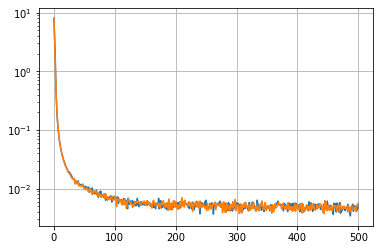

In [8]:
plt.semilogy(loss1_sv)
plt.semilogy(loss2_sv)
plt.grid()

# Symbol Error Rate

In [9]:
@tf.function
def get_SER(L, sigma2):
    #s1 = tf.random.uniform(shape=(L,), minval=0, maxval=M, dtype=tf.dtypes.int64)
    #s2 = tf.random.uniform(shape=(L,), minval=0, maxval=M, dtype=tf.dtypes.int64)
    s1 = tf.tile(tf.repeat(tf.range(M, dtype=tf.dtypes.int64), M), [L//(M*M)])
    s2 = tf.tile(tf.range(M, dtype=tf.dtypes.int64), [L//M])
    ohv1 = tf.one_hot(s1, depth=M)
    ohv2 = tf.one_hot(s2, depth=M)
    
    pxy1, pxy2 = model(ohv1, ohv2, sigma2)
    shat1 = tf.math.argmax(pxy1, axis=1)
    shat2 = tf.math.argmax(pxy2, axis=1)
    err_vec1 = tf.cast(s1 != shat1, dtype = tf.dtypes.int64)
    err_vec2 = tf.cast(s2 != shat2, dtype = tf.dtypes.int64)
    
    return tf.reduce_sum(err_vec1), tf.reduce_sum(err_vec2)

In [10]:
minErr = 3000
maxSym = minErr/1e-5
L = 65536 # batch size for evaluation 

if k == 4:
    R = 1
    SNRmax = 11
elif k == 8:
    R = 2
    SNRmax = 15

SNR_dB = np.arange(0, SNRmax, 1)
SNR_r = 10**(SNR_dB/10)

SNRlen = len(SNR_dB)
SymErrs = np.zeros([2, SNRlen])
Syms = np.zeros([2, SNRlen])

for II in range(SNRlen):
    print("SNR = {} dB".format(SNR_dB[II]))
    totErr, totSym = np.zeros(2), 0
    sigma2 = 1/(2*R*SNR_r[II])

    while ((totErr < minErr).any() and (totSym <= maxSym)):
        t1, t2 = get_SER(L,sigma2)
        totErr = totErr + np.asarray([t1.numpy(), t2.numpy()])
        totSym = totSym + L
    
    print(totErr)
    SymErrs[:,II] = totErr
    Syms[:,II] = totSym

print(SymErrs)
SER = SymErrs/Syms
print(SER)

SNR = 0 dB
[45624. 45832.]
SNR = 1 dB
[40680. 40596.]
SNR = 2 dB
[34759. 34762.]
SNR = 3 dB
[28395. 28407.]
SNR = 4 dB
[21631. 21621.]
SNR = 5 dB
[15339. 15267.]
SNR = 6 dB
[9640. 9771.]
SNR = 7 dB
[5313. 5426.]
SNR = 8 dB
[5149. 5094.]
SNR = 9 dB
[3115. 3066.]
SNR = 10 dB
[3119. 3121.]
SNR = 11 dB
[3068. 3081.]
SNR = 12 dB
[3047. 3009.]
SNR = 13 dB
[3011. 3001.]
SNR = 14 dB
[398. 452.]
[[45624. 40680. 34759. 28395. 21631. 15339.  9640.  5313.  5149.  3115.
   3119.  3068.  3047.  3011.   398.]
 [45832. 40596. 34762. 28407. 21621. 15267.  9771.  5426.  5094.  3066.
   3121.  3081.  3009.  3001.   452.]]
[[6.96166992e-01 6.20727539e-01 5.30380249e-01 4.33273315e-01
  3.30062866e-01 2.34054565e-01 1.47094727e-01 8.10699463e-02
  3.92837524e-02 1.58437093e-02 4.75921631e-03 1.11461821e-03
  1.83768894e-04 2.04560169e-05 1.32656139e-06]
 [6.99340820e-01 6.19445801e-01 5.30426025e-01 4.33456421e-01
  3.29910278e-01 2.32955933e-01 1.49093628e-01 8.27941895e-02
  3.88641357e-02 1.55944824e-02

In [11]:
def data2tikz(x,y):
    for i in range(len(x)):
        print("{0:.10f} {1:.10f}".format(x[i],y[i]))
        
data2tikz(SNR_dB, SER[0,:])

0.0000000000 0.6961669922
1.0000000000 0.6207275391
2.0000000000 0.5303802490
3.0000000000 0.4332733154
4.0000000000 0.3300628662
5.0000000000 0.2340545654
6.0000000000 0.1470947266
7.0000000000 0.0810699463
8.0000000000 0.0392837524
9.0000000000 0.0158437093
10.0000000000 0.0047592163
11.0000000000 0.0011146182
12.0000000000 0.0001837689
13.0000000000 0.0000204560
14.0000000000 0.0000013266


In [12]:
from io import StringIO

tmpstr = StringIO("""
0.0084566596, 0.2546798295
0.9852008457, 0.1837829326
2.0126849894, 0.1184593874
2.9894291755, 0.0699337229
3.9915433404, 0.0355147465
4.9936575053, 0.0151299158
6.0084566596, 0.0050150178
7.0105708245, 0.0012933516
8.0000000000, 0.0002289144
9.0021141649, 0.0000242212
""")

OShea_AE44 = np.genfromtxt(tmpstr, delimiter=',')

tmpstr = StringIO("""
-0.0042283298, 0.6862972546
0.9978858351, 0.6130077146
2.0000000000, 0.5339743994
3.0021141649, 0.4313972618
4.0042283298, 0.3273304262
4.9936575053, 0.2274826238
6.0084566596, 0.1429925304
6.9978858351, 0.0792834539
7.9873150106, 0.0378143531
9.0021141649, 0.0145709457
10.0042283298, 0.0045360282
11.0063424947, 0.0010849815
11.9957716702, 0.0001849396
12.9978858351, 0.0000216346
""")

OShea_AE84 = np.genfromtxt(tmpstr, delimiter=',')

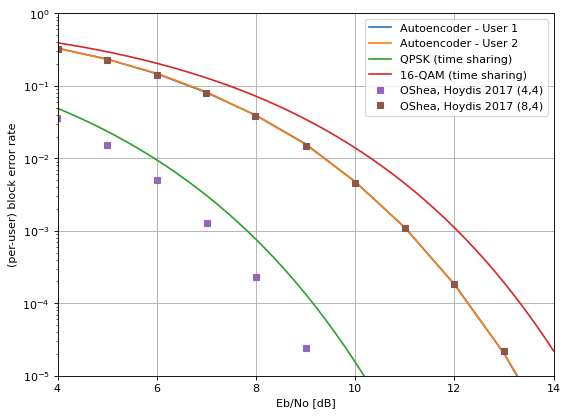

In [13]:
def qfunc(x):
    return 0.5 - 0.5*special.erf(x/sqrt(2))

SNRmin = 0
SNRmax = 14
dSNR = 0.1
SNR_dB2 = np.arange(SNRmin, SNRmax+dSNR, dSNR)
SNR_r = 10**(SNR_dB2/10)

# 16-QAM in 2 complex-valued channels uses
R = 2
sigma2 = 1/(2*R*SNR_r);
d2 = np.sqrt(1/10); 
SEP = 3/2*qfunc(sqrt(2)*d2/sqrt(sigma2)); # sqrt(2) adjusts for time-sharing
SEP_QAM = 1-(1-SEP)**4;

# QPSK in 2 complex-valued channel uses
R = 1
sigma2 = 1/(2*R*SNR_r);
d2 = np.sqrt(1/2)
SEP = qfunc(sqrt(2)*d2/sqrt(sigma2)) # sqrt(2) adjusts for time-sharing
SEP = 1-(1-SEP)**4

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.semilogy(SNR_dB, SER[0,:], label='Autoencoder - User 1')
plt.semilogy(SNR_dB, SER[1,:], label='Autoencoder - User 2')
plt.semilogy(SNR_dB2, SEP, label='QPSK (time sharing)')
plt.semilogy(SNR_dB2, SEP_QAM, label='16-QAM (time sharing)')

plt.semilogy(OShea_AE44[:,0], OShea_AE44[:,1], marker='s', linestyle='None', label='OShea, Hoydis 2017 (4,4)')
plt.semilogy(OShea_AE84[:,0], OShea_AE84[:,1], marker='s', linestyle='None', label='OShea, Hoydis 2017 (8,4)')
plt.xlabel('Eb/No [dB]')
plt.ylabel('(per-user) block error rate')
plt.ylim(1e-5, 1)
plt.xlim(4, 14)
plt.legend()
plt.grid()
plt.show()

# Plot Constellation

In [14]:
def plot_const(const1, const2):
    fig = plt.figure(figsize=(n*3+2,3))
    for i in range(n):
        ax1 = fig.add_subplot(1, n, i+1)
        x = const1[:, 2*i]
        y = const1[:, 2*i+1]
        ax1.scatter(x, y, c='k', marker='x')
        x = const2[:, 2*i]
        y = const2[:, 2*i+1]
        ax1.scatter(x, y, c='r', marker='o')

        plt.grid()
        max_axis = 2.5
        plt.xlim(-max_axis, max_axis)
        plt.ylim(-max_axis, max_axis)
    plt.show()    

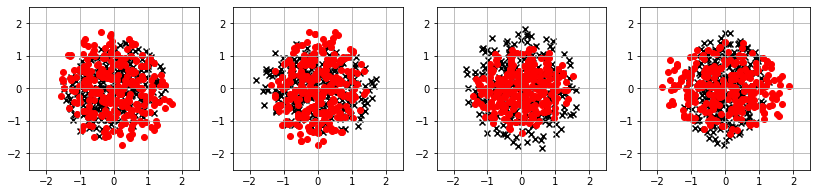

In [15]:
const1 = model.Encoder1(tf.eye(M))
const2 = model.Encoder2(tf.eye(M))
plot_const(const1, const2)

# Rotate the learned Solution

In [19]:
def Givens(i,j,theta):
    """returns a Givens rotation matrix as a 2D list"""
    Glist = [[0] * N for i in range(N)]
    for k in range(N):
        Glist[k][k] = 1
    Glist[i][i] = tf.cos(theta)
    Glist[j][j] = tf.cos(theta)
    Glist[i][j] = -tf.sin(theta)
    Glist[j][i] = tf.sin(theta)
    return Glist

In [20]:
G = []
theta = []

for i in range(N):
    for j in range(i+1,N):
        tmp = tf.Variable(tf.random.uniform(shape=(1,), minval=0, maxval=2*pi), trainable=True)
        theta.append(tmp)
        G.append(Givens(i,j,tmp))

In [21]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
const1 = model.Encoder1(tf.eye(M))
const2 = model.Encoder2(tf.eye(M))

def init_theta():
    theta = []
    for i in range(N):
        for j in range(i+1,N):
            tmp = tf.Variable(tf.random.uniform(shape=(), minval=0, maxval=2*pi), trainable=True)
            theta.append(tmp)
    return theta

@tf.function # debug in eager mode, then compile into a static graph (faster)
def train_step_eager(theta):
    with tf.GradientTape() as tape:
        X1 = tf.transpose(const1) # NxM
        X2 = tf.transpose(const2)
        
        tmp = 0
        for i in range(N):
            for j in range(i+1,N):
                R = tf.convert_to_tensor(Givens(i,j, theta[tmp]))
                tmp = tmp + 1
                #print(R)
                X1 = tf.matmul(R, X1)
                X2 = tf.matmul(R, X2)
        
        X1 = X1[0:N//2,:]
        X2 = X2[N//2:,:]
        
        loss = tf.reduce_sum(X1**2)+tf.reduce_sum(X2**2)
    
    grads = tape.gradient(loss, theta)
    #print(grads)
    optimizer.apply_gradients(zip(grads, theta))    
    return loss

In [22]:
iterations = 500
print_interval = 10
runs = 5 # assuming different initializations
start_time = time.time()

loss_sv = np.zeros([iterations//print_interval+1, runs])
iter_sv = np.zeros([iterations//print_interval+1, runs])
theta_sv = np.zeros([N*(N-1)//2, runs])
theta_sv2 = np.zeros([N*(N-1)//2, runs])

for RR in range(runs):
    theta = init_theta()
    theta_tmp = [theta[i].numpy() for i in range(len(theta))]
    theta_sv2[:, RR] = np.asarray(theta_tmp)
    i_sv = 0
    for i in range(1, iterations+1):
        loss = train_step_eager(theta)

        if i%print_interval==0 or i==1:
            #print('iter ', i, 'L1', float(L1), 'L2', float(L2), 'alpha', float(alpha))
            loss_sv[i_sv,RR] = loss.numpy()
            iter_sv[i_sv,RR] = i
            i_sv = i_sv + 1
            print('iter {:5d}: loss = {:.5f}'.format(i, loss.numpy()))
    theta_tmp = [theta[i].numpy() for i in range(len(theta))]
    theta_sv[:, RR] = np.asarray(theta_tmp)

elapsed = time.time() - start_time
print("{0:.2f} seconds".format(elapsed))

iter     1: loss = 1221.45874
iter    10: loss = 436.63635
iter    20: loss = 246.97162
iter    30: loss = 142.38547
iter    40: loss = 92.79260
iter    50: loss = 59.29909
iter    60: loss = 38.07704
iter    70: loss = 23.26707
iter    80: loss = 13.57500
iter    90: loss = 7.68507
iter   100: loss = 4.28022
iter   110: loss = 2.36943
iter   120: loss = 1.31497
iter   130: loss = 0.73849
iter   140: loss = 0.42498
iter   150: loss = 0.25498
iter   160: loss = 0.16294
iter   170: loss = 0.11315
iter   180: loss = 0.08624
iter   190: loss = 0.07169
iter   200: loss = 0.06384
iter   210: loss = 0.05959
iter   220: loss = 0.05729
iter   230: loss = 0.05606
iter   240: loss = 0.05539
iter   250: loss = 0.05503
iter   260: loss = 0.05483
iter   270: loss = 0.05473
iter   280: loss = 0.05467
iter   290: loss = 0.05464
iter   300: loss = 0.05462
iter   310: loss = 0.05461
iter   320: loss = 0.05461
iter   330: loss = 0.05460
iter   340: loss = 0.05460
iter   350: loss = 0.05460
iter   360: lo

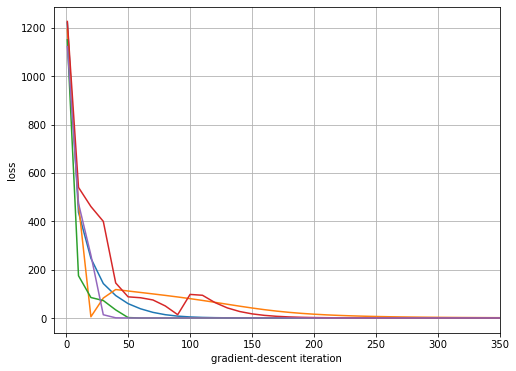

In [23]:
plt.figure(figsize=(8,6))
plt.plot(iter_sv,loss_sv)
plt.xlabel('gradient-descent iteration')
plt.ylabel('loss')
plt.xlim(-10, 350)
#plt.xlim(SNRmin, SNRmax)
#plt.legend()
font = {'weight' : 'normal', 'size'   : 15}
plt.rc('font', **font)
plt.grid()
plt.show()

# Plot Rotated Constellation

In [24]:
def get_R(theta):
    tmp = 0
    Rtot = tf.eye(N, dtype=tf.float32)
    for i in range(N):
        for j in range(i+1,N):
            G = Givens(i,j, theta[tmp])
            tmp = tmp + 1
            R = tf.convert_to_tensor(G, dtype=tf.float32)
            #print(R)
            Rtot = tf.matmul(R, Rtot)
    return Rtot

In [25]:
#np.set_printoptions(precision=2)

run_index = 4
Rtot = get_R(theta_sv[:,run_index]) # get the rotation matrix of a particular run
print(tf.round(Rtot@tf.transpose(Rtot)))

tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]], shape=(8, 8), dtype=float32)


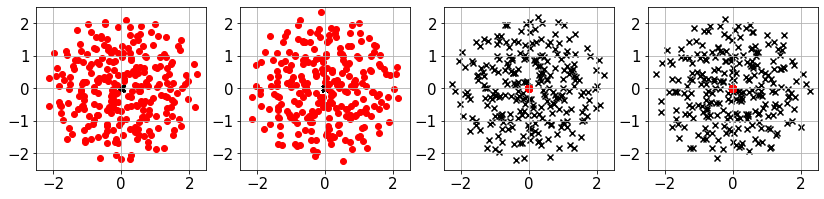

In [26]:
const1 = tf.transpose(tf.matmul(Rtot, tf.transpose(model.Encoder1(tf.eye(M)))))
const2 = tf.transpose(tf.matmul(Rtot, tf.transpose(model.Encoder2(tf.eye(M)))))
plot_const(const1, const2)